## Calculation of a confident interval for LSTM model of time-series

References:

1. The book "Hands-On Machine Learning with Scikit-Learn and TensorFlow"
    - By: Manpreet Singh Ghotra; Rajdeep Dua
    - Publisher: Packt Publishing
    - Pub. Date: November 10, 2017
2. [Applying Deep Learning to Time Series Forecasting with TensorFlow](https://mapr.com/blog/deep-learning-tensorflow/)
3. [hunkim/DeepLearningZeroToAll](https://github.com/hunkim/DeepLearningZeroToAll/blob/master/lab-12-5-rnn_stock_prediction.py)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import importlib
import pathlib
import shutil
%matplotlib inline

In [2]:
import tensorflow as tf
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as tfmetrics
import tensorflow.contrib.rnn as tfrnn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
tf.__version__

'1.3.0'

In [3]:
# Add files from ../src
p_src = [pathlib.Path("../src"), pathlib.Path('../historical_data')]
path_add = [p.resolve().expanduser().absolute() for p in p_src]
import os, sys
for elem in path_add:
    sys.path.append(str(elem))
import data_generator  # initial import
import lstm_model
import utils

In [4]:
# Parameters
import os
try:
    os.path.mkdir('models')
except:
    pass
# MODEL_PATH = os.path.join('models', "lstm-5-model")
STATE_FOLD = "model_state"
MODEL_NAME = "lstm-8"

DATA_FILE = '../historical_data/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv'
INPUTS = 1  # how many inputs
OUTPUTS = 1  # how many outputs

In [5]:
# Start from here if files in ../src has been changed without restarting the notebook
importlib.reload(lstm_model)
importlib.reload(utils)
tr = utils.TimeRec()
vals, dates = data_generator.csv_reader(DATA_FILE, 'Weighted_Price', 'Timestamp')
vals_len = vals.shape[0]
str(tr), vals_len

('Total: 1.605 sec', 1574274)

### Two sets of parameters.

The CHECK_SETS is used for tuning the software, an algorithm, a graph representaion.<br/>
The GPU_SETS is used to train the model on a computer with GPU. For this example it is a computer on Google Cloud

In [6]:
CHECK_SETS = lstm_model.Settings(model_name=MODEL_NAME, state_fold=STATE_FOLD, data_file=DATA_FILE,
                      neurons=[32], loss=0.1, x_steps=20, x_features=1, y_features=1, 
                      learning_rate=0.001, train_sz=1000, validate_sz=vals_len//2, batch_sz=20, epochs=10)

GPU_SETS = lstm_model.Settings(model_name=MODEL_NAME, state_fold=STATE_FOLD, data_file=DATA_FILE,
                    neurons=[32, 64], loss=0.05, x_steps=200, x_features=1, y_features=1, 
                    learning_rate=0.003, train_sz=10000, validate_sz=vals_len//2, batch_sz=300, epochs=100)
    
SETS = GPU_SETS
SETS.to_json()

### Show the whole training data set and selected range

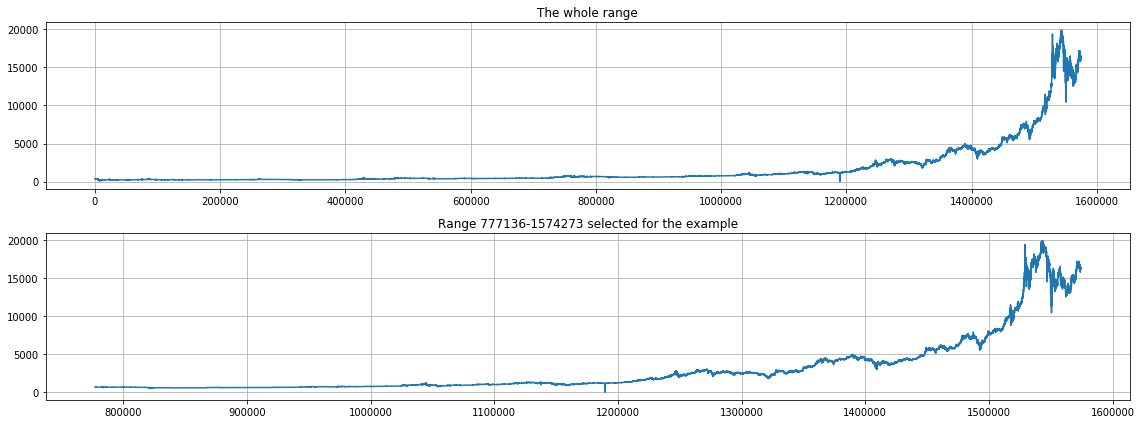

In [7]:
plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
plt.plot(vals)
plt.grid(True)
plt.title("The whole range")
plt.subplot(2,1,2)
xmax = vals_len - 1
xmin = xmax - SETS.train_sz - SETS.validate_sz
plt.plot(list(np.linspace(xmin, xmax-1, xmax-xmin)), vals[xmin:xmax])
plt.title("Range {}-{} selected for the example".format(xmin, xmax))
plt.grid(True)
plt.tight_layout()

In [8]:
# Selected range is from TRAIN_BG until the end
validate_bg = vals_len - SETS.validate_sz
train_bg = validate_bg - SETS.train_sz
validation_vals = vals[validate_bg:]
train_vals = vals[train_bg:validate_bg]
train_dates = np.linspace(0, SETS.train_sz-1, SETS.train_sz)
validation_dates = np.linspace(SETS.train_sz, SETS.train_sz+SETS.validate_sz-1, SETS.validate_sz)
train_bg, validate_bg

(777137, 787137)

In [9]:
# Create a data source. Actual dates are not interesting and has been replaced to indexes.
importlib.reload(data_generator)

data_source = data_generator.BatchGenerator(
    data=train_vals, dates=train_dates, batch_size=SETS.batch_sz,
    x_steps=SETS.x_steps, y_features=SETS.y_features,
    align_size=True, noise_std=0)
data_source.scale()

### The LSTM model

In [10]:
# If src/model.py has been changed
importlib.reload(lstm_model)

<module 'lstm_model' from '/home/rtaubes/job/bitcoin-price/src/lstm_model.py'>

In [11]:
# Use this cell to create a new model and reset checkpoints
model = lstm_model.Model(SETS, data_source)
model.create()
mse_coll = []

In [ ]:
# Use this cell to create a new model and continue training from the latest checkpoint
model = lstm_model.Model(SETS, data_source)
model.from_latest_point()

### The training step(s). 
For the first pass any of create(), or from_latest_point(), or from_custom_point() defines the input data source.
For the each next pass, the cell below uses data from the latest checkpoint.<br/>
The 'epochs' parameter in SETS defines the number of epochs for the each start of the cell. Repeat the cell below until you decide that training is no longer required.

In [18]:
mse_lst = model.train()
mse_coll += mse_lst

INFO:tensorflow:Restoring parameters from model_state/lstm-8/ckpt/checkpoint-99
model restored from model_state/lstm-8/ckpt/checkpoint-99
epoch_offset: 100
  1/100: 11.5 sec:  MSE: 0.000941, saved to 'model_state/lstm-8/ckpt/checkpoint-100'
  2/100: 10.9 sec:  MSE: 0.001493
  3/100: 10.6 sec:  MSE: 0.000945
  4/100: 10.7 sec:  MSE: 0.000649
  5/100: 10.7 sec:  MSE: 0.000487
  6/100: 10.6 sec:  MSE: 0.000642
  7/100: 10.8 sec:  MSE: 0.000472
  8/100: 10.8 sec:  MSE: 0.000540
  9/100: 10.7 sec:  MSE: 0.000496
 10/100: 10.7 sec:  MSE: 0.000573
 11/100: 10.9 sec:  MSE: 0.000467, saved to 'model_state/lstm-8/ckpt/checkpoint-110'
 12/100: 10.7 sec:  MSE: 0.000518
 13/100: 10.7 sec:  MSE: 0.000515
 14/100: 10.8 sec:  MSE: 0.000516
 15/100: 10.7 sec:  MSE: 0.000451
 16/100: 10.7 sec:  MSE: 0.000601
 17/100: 10.8 sec:  MSE: 0.000550
 18/100: 10.8 sec:  MSE: 0.000676
 19/100: 10.8 sec:  MSE: 0.000704
 20/100: 10.9 sec:  MSE: 0.000694
 21/100: 10.9 sec:  MSE: 0.000509, saved to 'model_state/lstm-

Plot MSE as summary for all starts of training above

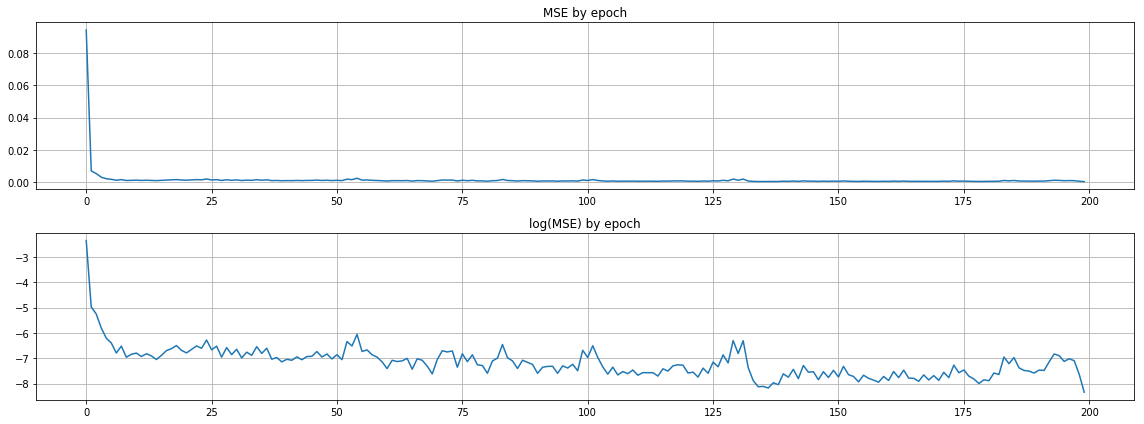

In [19]:
plt.figure(figsize=(16, 6))
plt.subplot(211)
plt.plot(mse_coll, label='mse')
plt.title("MSE by epoch")
plt.grid(True)
plt.subplot(212)
plt.plot(np.log(mse_coll), label='log(mse)')
plt.title("log(MSE) by epoch")
plt.grid(True)
plt.tight_layout()

### Actual and predicted data for the training set. 
It is shows how well the model can reproduce actual data. Actually, the latest part is more important than the beginning, because the last part is used as independent variable X to create a forecast as Y=f(X).

Model.delete()
INFO:tensorflow:Restoring parameters from model_state/lstm-8/ckpt/checkpoint-199
model restored from model_state/lstm-8/ckpt/checkpoint-199
step: 0
step: 2000
step: 4000
step: 6000
step: 8000
test steps: 9700, total time: 615.967


Text(0.5,1,'Actual vs Predicts. MSE=0.000108')

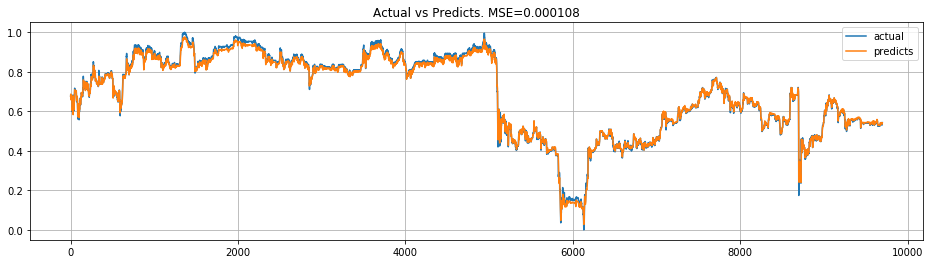

In [20]:
model = lstm_model.Model(SETS, data_source)
model.from_latest_point()
idx, actual, predicts = model.evaluate()
eval_mse = mean_squared_error(actual, predicts)
plt.figure(figsize=(16, 4))
plt.plot(actual, label='actual')
plt.plot(predicts, label='predicts')
plt.legend()
plt.grid()
plt.title('Actual vs Predicts. MSE={:.6f}'.format(eval_mse))

The latest part of a training set which is used in a prediction.

Text(0.5,1,'Actual vs Predicts. Last 400 values')

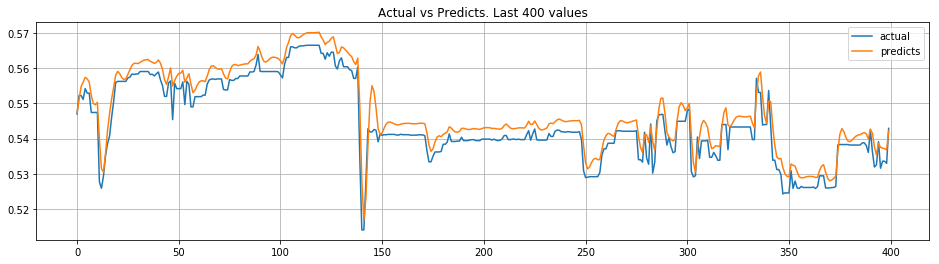

In [21]:
look_back = 400
plt.figure(figsize=(16, 4))
plt.plot(actual[-look_back:], label='actual')
plt.plot(predicts[-look_back:], label='predicts')
plt.legend()
plt.grid()
plt.title('Actual vs Predicts. Last {} values'.format(look_back))

The historgram and box plot of error between the predicted and actual values of training set. The histogram shows that the distribution looks like to skewed normal.

errors description: count    9699.000000
mean        0.004425
std         0.009382
min        -0.155639
25%        -0.002463
50%         0.003577
75%         0.010689
max         0.106330
Name: error, dtype: float64


Text(0.5,1,'Error')

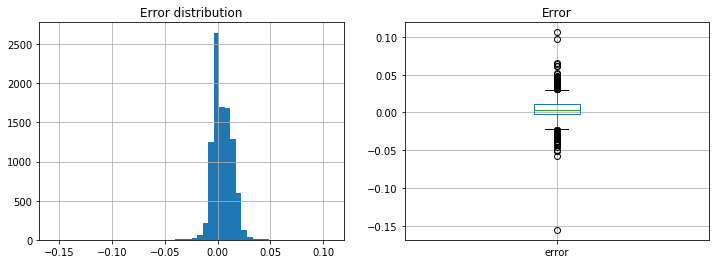

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
df = pd.DataFrame({'actual': actual, 'predicts': predicts})
df['error'] = df.actual - df.predicts
print("errors description:", df.error.describe())
df.error.hist(bins=50).set_title('Error distribution')
plt.subplot(122)
df.error.plot(kind='box', grid=True).set_title("Error")

### Calculate a confidence interval for forecasting and define decitions when the model produces a correct prediction

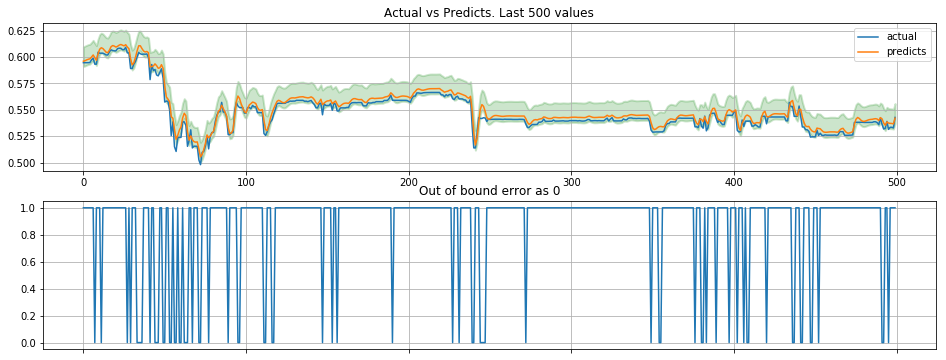

In [23]:
look_back = 500
std_part = 1.0  # use values from 0 to 1 if you have an idea what part of STD should be used.
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(211)
act_lb = actual[-look_back:]
pred_lb = predicts[-look_back:]
err_std = df.error.std(axis=0)
err_mean = df.error.mean(axis=0)
pred_upper = pred_lb + err_mean + err_std * std_part
pred_lower = pred_lb + err_mean - err_std * std_part
err_x = np.linspace(0, len(act_lb)-1, len(act_lb))
plt.plot(actual[-look_back:], label='actual')
plt.plot(predicts[-look_back:], label='predicts')
plt.fill_between(x=err_x, y1=pred_upper, y2=pred_lower, color='green', lw=2, alpha=0.2)
plt.legend()
plt.grid()
plt.title('Actual vs Predicts. Last {} values'.format(look_back))
ax2 = plt.subplot(212, sharex=ax1)
less_upp = act_lb < pred_upper
more_lower = act_lb > pred_lower
plt.plot(np.logical_and(less_upp, more_lower))
plt.title("Out of bound error as 0")
plt.grid()
plt.setp(ax2.get_xticklabels(), visible=False);

The first graph shows the actual and predicted values, and calculated confidence interval as a filled area. The second graph depicts when the confidence interval covers the values from training set( the '1' value). 

For this particular example, for data in X range [150, 400], the model can't reproduce the training set with appropriate precision. For X in range [620, 800] the model can predict data well.